# Predict Future Sales
Predict total sales for every product and store in the next month

## Loading the Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from statsmodels.api import OLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

In [2]:
items = pd.read_csv("items.csv")
item_categories = pd.read_csv("item_categories.csv")
sales_train = pd.read_csv("sales_train.csv")
shops = pd.read_csv("shops.csv")
sample_submission = pd.read_csv("sample_submissionpredict.csv")
sales_test = pd.read_csv("testpredict.csv")
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
sales_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
[sales_train.shape, sales_test.shape]

[(2935849, 6), (214200, 3)]

## Visualization

c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='item_cnt_day'>

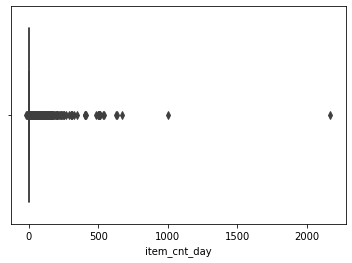

In [5]:
sns.boxplot(sales_train["item_cnt_day"])

c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='item_price'>

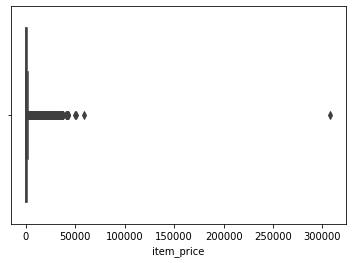

In [6]:
sns.boxplot(sales_train["item_price"])

In [7]:
sales_train["item_cnt_day"] = sales_train["item_cnt_day"].clip(0,200)
sales_train["item_price"] = sales_train["item_price"].clip(0,5000)


<AxesSubplot:xlabel='date_block_num'>

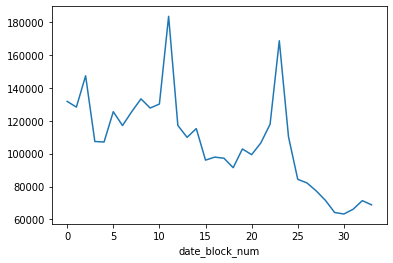

In [8]:
sales_train.groupby("date_block_num")["item_cnt_day"].sum().plot()

array([<AxesSubplot:ylabel='0'>], dtype=object)

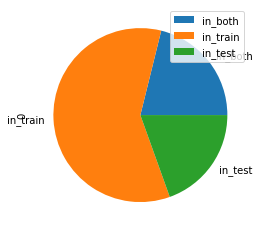

In [9]:
# distribution of shop_item combinations in train and test set
# only a few shops/items are in test and train set
# no leakage can be identified, split seems random

train_unique = sales_train.groupby(["shop_id", "item_id"]).size()
test_unique = sales_test.groupby(["shop_id", "item_id"]).size()

train_unique = pd.DataFrame({"in_train":True}, index=train_unique.index)
test_unique = pd.DataFrame({"in_test":True}, index=test_unique.index)

combined = pd.merge(train_unique, test_unique, on=["shop_id", "item_id"], how="outer").fillna(False)

combined["in_both"] = combined["in_train"] & combined["in_test"]

num_in_both = sum(combined["in_both"] == True)
num_in_train = sum((combined["in_train"] == True) & (combined["in_test"] == False))
num_in_test = sum((combined["in_test"] == True) & (combined["in_train"] == False))

pd.DataFrame({"in_both":[num_in_both], 
              "in_train": [num_in_train],
              "in_test": [num_in_test]}).T.plot.pie(subplots=True)

In [10]:
from itertools import product

matrix = []
index_cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = sales_train[sales_train.date_block_num == i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype=np.int16))

matrix = pd.DataFrame(np.vstack(matrix), columns=index_cols)
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values(index_cols, inplace = True )
matrix

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32
...,...,...,...
10768834,33,59,22162
10769024,33,59,22163
10769690,33,59,22164
10771216,33,59,22166


In [11]:
# add target variable (item counts for each month) to data
item_counts = sales_train.groupby(index_cols).agg({"item_cnt_day": ["sum"]}).reset_index()

matrix = pd.merge(matrix, item_counts, on=index_cols, how="left")
matrix.fillna(0, inplace=True)
matrix.rename(columns={matrix.columns[-1]: "item_cnt_month"}, inplace=True)
matrix["item_cnt_month"] = matrix["item_cnt_month"].clip(0,20).astype(np.float16)
matrix

c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0
...,...,...,...,...
10913845,33,59,22162,0.0
10913846,33,59,22163,0.0
10913847,33,59,22164,0.0
10913848,33,59,22166,0.0


In [12]:
# add test data to matrix
sales_test["date_block_num"] = 34
matrix = pd.concat([matrix, sales_test.drop(["ID"], axis=1)], ignore_index=True, keys=index_cols)
matrix.fillna(0, inplace=True)
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0
...,...,...,...,...
11128045,34,45,18454,0.0
11128046,34,45,16188,0.0
11128047,34,45,15757,0.0
11128048,34,45,19648,0.0


In [13]:
# downgrade types
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.dtypes

date_block_num       int8
shop_id              int8
item_id             int16
item_cnt_month    float16
dtype: object

## Feature Generation

In [14]:
# lag features and mean encoding

def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

lag_dates = [1,2,3,6,12]

matrix = lag_feature(matrix, lag_dates, "item_cnt_month")
matrix.fillna(0, inplace=True)

# mean item count per month
feature = matrix.groupby(['date_block_num']).agg({'item_cnt_month': 'mean'})
feature.index = feature.index+1
feature.columns = ["item_cnt_month_mean_lag_1"]
matrix = pd.merge(matrix, feature, on=["date_block_num"], how="left")

# item category
matrix = pd.merge(matrix, items.drop(["item_name"], axis=1), how="left", on="item_id")

# mean count of item_id
feature = matrix.groupby(['date_block_num', "item_id"]).agg({'item_cnt_month': 'mean'}).reset_index()
feature
feature.rename({"item_cnt_month": "means_cnt_item_id_lag_1"}, axis=1, inplace=True)
feature["date_block_num"] += 1
feature
matrix = pd.merge(matrix, feature, on=["date_block_num", "item_id"], how="left")

# mean count of shop_id
feature = matrix.groupby(['date_block_num', "shop_id"]).agg({'item_cnt_month': 'mean'}).reset_index()
feature
feature.rename({"item_cnt_month": "means_cnt_shop_id_lag_1"}, axis=1, inplace=True)
feature["date_block_num"] += 1
feature
matrix = pd.merge(matrix, feature, on=["date_block_num", "shop_id"], how="left")

# number of counts for shop/item id combination per date_block_num
piv = sales_train.pivot_table(values="item_price", index=["shop_id", "item_id"] ,columns="date_block_num", aggfunc="mean")
piv = piv.fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)
piv_diff = piv.diff(axis=1)
piv_diff.columns += 1
piv_div = piv_diff.stack()
piv_div.name = "price_diff_lag_1"
matrix = pd.merge(matrix, piv_div, on=["shop_id", "item_id", "date_block_num"], how="left")

matrix.fillna(0, inplace=True)

In [15]:
# textual and coordinate features from shop and category

shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

shops['city_coord_1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_coord_2'] = shops['city'].apply(lambda x: coords[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])

shops = shops[['shop_id', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part']]

matrix = pd.merge(matrix, shops, on=["shop_id"], how="left")



In [16]:
# features about items and their category names (common category and category code)

map_dict = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители',
            'PC ': 'Аксессуары',
            'Служебные': 'Служебные '
            }

items = pd.merge(items, item_categories, on='item_category_id')

items['item_category'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items['item_category'] = items['item_category'].apply(lambda x: map_dict[x] if x in map_dict.keys() else x)
items['item_category_common'] = LabelEncoder().fit_transform(items['item_category'])

items['item_category_code'] = LabelEncoder().fit_transform(items['item_category_name'])
items = items[['item_id', 'item_category_common', 'item_category_code']]

matrix = pd.merge(matrix, items, on=['item_id'], how='left')

In [17]:
# interaction features: 
# - is item new
# - has it been bought in shop before

first_item_block = matrix.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1

first_shop_item_buy_block = matrix[matrix['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']

matrix = pd.merge(matrix, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
matrix = pd.merge(matrix, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

matrix['first_date_block_num'].fillna(100, inplace=True)
matrix['shop_item_sold_before'] = (matrix['first_date_block_num'] < matrix['date_block_num']).astype('int8')
matrix.drop(['first_date_block_num'], axis=1, inplace=True)

matrix['item_first_interaction'].fillna(0, inplace=True)
matrix['shop_item_sold_before'].fillna(0, inplace=True)
 
matrix['item_first_interaction'] = matrix['item_first_interaction'].astype('int8')  
matrix['shop_item_sold_before'] = matrix['shop_item_sold_before'].astype('int8')

In [18]:
matrix.head()


,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_cnt_month_mean_lag_1,...,means_cnt_shop_id_lag_1,price_diff_lag_1,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,item_first_interaction,shop_item_sold_before
0,0,0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,29,62.028098,129.732555,4,11,40,1,0
1,0,0,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,29,62.028098,129.732555,4,5,19,1,0
2,0,0,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,29,62.028098,129.732555,4,8,30,1,0
3,0,0,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,29,62.028098,129.732555,4,5,23,1,0
4,0,0,32,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,29,62.028098,129.732555,4,11,40,1,0


In [19]:
# remove first 12 months and split into train, validation and test data
matrix = matrix[matrix["date_block_num"] >= 12]

X_train = matrix[matrix["date_block_num"] < 33].drop(["item_cnt_month"], axis=1)
X_val = matrix[matrix["date_block_num"] == 33].drop(["item_cnt_month"], axis=1)
X_test = matrix[matrix["date_block_num"] == 34].drop(["item_cnt_month"], axis=1)

y_train = matrix[matrix["date_block_num"] < 33]["item_cnt_month"]
y_val = matrix[matrix["date_block_num"] == 33]["item_cnt_month"]

In [20]:
# quick linear regression analysis on validation data

results = sm.OLS(y_val.to_numpy(), X_val.astype(float)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     5396.
Date:                Thu, 01 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:44:44   Log-Likelihood:            -3.2779e+05
No. Observations:              238172   AIC:                         6.556e+05
Df Residuals:                  238153   BIC:                         6.558e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
date_block_num                0.0102      0.000     22.912      0.000       0.009       0.011
shop_id                      -0.0053      0.001     -7.715      0.000      -0.007      -0.004
item_id                     3.01e-06   3.36e-07      8.973      0.000    2.35e-06    3.67e-06
item_cnt_month_lag_1          0.2906      0.003    106.334      0.000       0.285       0.296
item_cnt_month_lag_2          0.1047      0.003     37.938      0.000       0.099       0.110
item_cnt_month_lag_3          0.1256      0.003     44.417      0.000       0.120       0.131
item_cnt_month_lag_6          0.0676      0.002     30.921      0.000       0.063       0.072
item_cnt_month_lag_12         0.0633      0.002     36.187      0.000       0.060       0.067
item_cnt_month_mean_lag_1  8.204e-05   3.58e-06     22.912      0.000     7.5e-05    8.91e-05
item_category_id             -0.0008      0.000     -4.787      0.000      -0.001      -0.000
means_cnt_item_id_lag_1       0.1645      0.004     44.437      0.000       0.157       0.172
means_cnt_shop_id_lag_1       0.3877      0.012     32.439      0.000       0.364       0.411
price_diff_lag_1              0.0002   2.77e-05      6.913      0.000       0.000       0.000
city_code                     0.0116      0.001      7.915      0.000       0.009       0.014
city_coord_1                 -0.0008      0.000     -4.422      0.000      -0.001      -0.000
city_coord_2                 -0.0005      0.000     -4.767      0.000      -0.001      -0.000
country_part                 -0.0123      0.002     -5.472      0.000      -0.017      -0.008
item_category_common          0.0052      0.002      2.701      0.007       0.001       0.009
item_category_code           -0.0008      0.000     -4.787      0.000      -0.001      -0.000
item_first_interaction        0.1071      0.013      8.400      0.000       0.082       0.132
shop_item_sold_before        -0.3361      0.011    -30.303      0.000      -0.358      -0.314
==============================================================================
Omnibus:                   375906.386   Durbin-Watson:                   1.449
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        296875169.086
Skew:                          10.153   Prob(JB):                         0.00
Kurtosis:                     174.764   Cond. No.                     2.43e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.71e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Validation and Testing

In [22]:
xgb_model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

xgb_model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)


[0]	validation_0-rmse:1.05226	validation_1-rmse:1.04557
[1]	validation_0-rmse:0.96742	validation_1-rmse:0.98236
[2]	validation_0-rmse:0.92080	validation_1-rmse:0.95131
[3]	validation_0-rmse:0.89023	validation_1-rmse:0.93244
[4]	validation_0-rmse:0.87380	validation_1-rmse:0.92279
[5]	validation_0-rmse:0.86426	validation_1-rmse:0.91534
[6]	validation_0-rmse:0.85783	validation_1-rmse:0.91003
[7]	validation_0-rmse:0.85106	validation_1-rmse:0.90787
[8]	validation_0-rmse:0.84478	validation_1-rmse:0.90807
[9]	validation_0-rmse:0.84117	validation_1-rmse:0.90114
[10]	validation_0-rmse:0.83856	validation_1-rmse:0.90312
[11]	validation_0-rmse:0.83584	validation_1-rmse:0.90334
[12]	validation_0-rmse:0.83421	validation_1-rmse:0.90340
[13]	validation_0-rmse:0.83217	validation_1-rmse:0.90372
[14]	validation_0-rmse:0.83139	validation_1-rmse:0.90363
[15]	validation_0-rmse:0.83019	validation_1-rmse:0.90526
[16]	validation_0-rmse:0.82968	validation_1-rmse:0.90584
[17]	validation_0-rmse:0.82821	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [23]:
lgbm_model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.03,
    num_leaves=32,
    colsample_bytree=0.9,
    subsample=0.8,
    max_depth=8,
    reg_alpha=0.04,
    reg_lambda=0.07,
    min_split_gain=0.02,
    min_child_weight=40,
    seed=42
)

lgbm_model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

[1]	training's rmse: 1.17589	training's l2: 1.38272	valid_1's rmse: 1.12708	valid_1's l2: 1.2703
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 1.16127	training's l2: 1.34854	valid_1's rmse: 1.11594	valid_1's l2: 1.24533
[3]	training's rmse: 1.14889	training's l2: 1.31995	valid_1's rmse: 1.10638	valid_1's l2: 1.22407
[4]	training's rmse: 1.13548	training's l2: 1.28932	valid_1's rmse: 1.0963	valid_1's l2: 1.20188
[5]	training's rmse: 1.12268	training's l2: 1.2604	valid_1's rmse: 1.08671	valid_1's l2: 1.18093
[6]	training's rmse: 1.11051	training's l2: 1.23322	valid_1's rmse: 1.07764	valid_1's l2: 1.1613
[7]	training's rmse: 1.09888	training's l2: 1.20754	valid_1's rmse: 1.06907	valid_1's l2: 1.14291
[8]	training's rmse: 1.08901	training's l2: 1.18593	valid_1's rmse: 1.06165	valid_1's l2: 1.12711
[9]	training's rmse: 1.07835	training's l2: 1.16285	valid_1's rmse: 1.05387	valid_1's l2: 1.11065
[10]	training's rmse: 1.06843	training's l2: 1.14155	valid_1'

[82]	training's rmse: 0.8658	training's l2: 0.74961	valid_1's rmse: 0.915602	valid_1's l2: 0.838327
[83]	training's rmse: 0.865299	training's l2: 0.748742	valid_1's rmse: 0.915379	valid_1's l2: 0.837918
[84]	training's rmse: 0.864756	training's l2: 0.747803	valid_1's rmse: 0.915324	valid_1's l2: 0.837818
[85]	training's rmse: 0.864255	training's l2: 0.746936	valid_1's rmse: 0.915121	valid_1's l2: 0.837447
[86]	training's rmse: 0.863806	training's l2: 0.746161	valid_1's rmse: 0.914935	valid_1's l2: 0.837107
[87]	training's rmse: 0.863359	training's l2: 0.745389	valid_1's rmse: 0.914777	valid_1's l2: 0.836818
[88]	training's rmse: 0.862924	training's l2: 0.744638	valid_1's rmse: 0.914566	valid_1's l2: 0.836431
[89]	training's rmse: 0.86248	training's l2: 0.743872	valid_1's rmse: 0.914357	valid_1's l2: 0.836049
[90]	training's rmse: 0.862067	training's l2: 0.74316	valid_1's rmse: 0.914228	valid_1's l2: 0.835814
[91]	training's rmse: 0.861693	training's l2: 0.742514	valid_1's rmse: 0.91403

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.03, max_depth=8,
              min_child_weight=40, min_split_gain=0.02, n_estimators=200,
              num_leaves=32, reg_alpha=0.04, reg_lambda=0.07, seed=42,
              subsample=0.8)

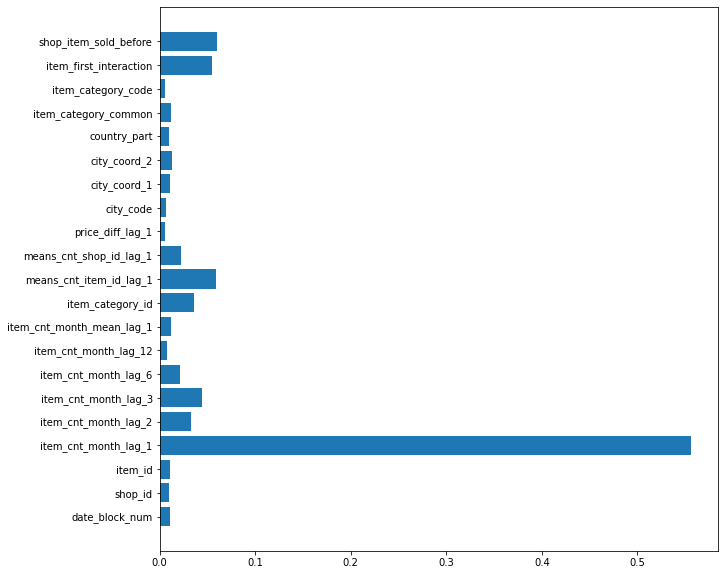

In [24]:
# xgb feature importance
cols = X_val.columns
plt.figure(figsize=(10,10))
plt.barh(cols, xgb_model.feature_importances_)
plt.show()

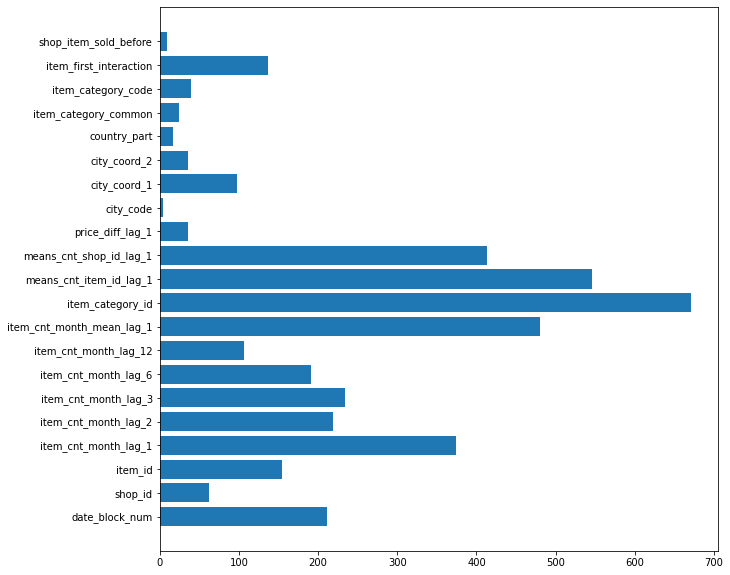

In [25]:
# lgbm feature importance

cols = X_val.columns
plt.figure(figsize=(10,10))
plt.barh(cols, lgbm_model.feature_importances_)
plt.show()

In [26]:
# predict and combine using a linear combination of results

xgb_preds = xgb_model.predict(X_test)
lgbm_preds = lgbm_model.predict(X_test)

final_preds = (xgb_preds + lgbm_preds) / 2
final_preds = final_preds.clip(0,20)
final_preds

array([0.57873239, 0.2255581 , 1.14766855, ..., 0.04344034, 0.02506928,
       0.02754528])

In [27]:
submission = pd.DataFrame({"item_cnt_month": final_preds})
submission.index.name="ID"
submission
submission.to_csv("submission.csv")